In [219]:
##### Combines the MapSPAM data into 1 map on crop production 

import os
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from glob import glob
import rasterio
from rasterio.warp import reproject, Resampling
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors

In [220]:
##### Load data

# Get the current working directory
cd = os.path.dirname(os.getcwd())

# Import data
livestock = rio.open_rasterio(f"{cd}/Data/Raw/FAO_gridded_livestock/GLW4-2020.D-DA.GLEAM3-ALL-LU.tif")

country_boundaries = gpd.read_file("/Users/carinamanitius/Documents/Data/Admin_Boundaries/simple_for_map/World_Countries_Generalized.shp")


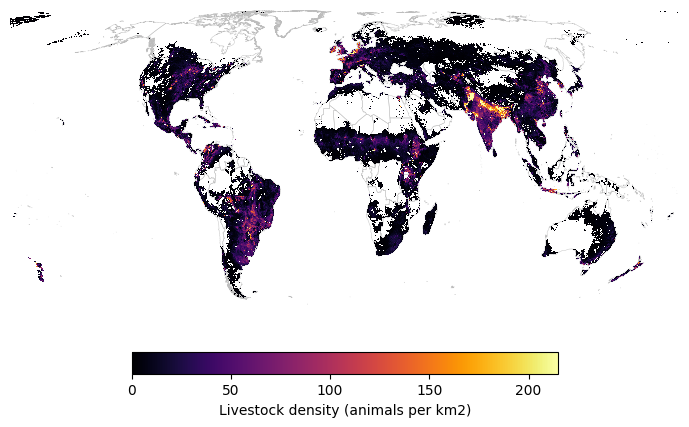

In [221]:
##### Produce global map fo livestock density

# Prepare raster
livestock_plot = livestock.squeeze()
livestock_masked = livestock_plot.where(livestock_plot > 1)

# Reproject masked raster to equal-area
livestock_eq = livestock_masked.rio.reproject("EPSG:8857")

# Match CRS for boundaries
country_boundaries = country_boundaries.to_crs(livestock_eq.rio.crs)

# Create figure
fig, ax = plt.subplots(figsize=(7, 5))

# Country borders underneath
country_boundaries.plot(
    ax=ax,
    facecolor="none",
    edgecolor="#bdbdbd",
    linewidth=0.3,
    zorder=1
)

# Raster on top (reprojected)
im = livestock_eq.plot(
    ax=ax,
    cmap="inferno",
    vmin=0,
    vmax=215,
    add_colorbar=False,
    add_labels=False,
    zorder=2
)

ax.set_axis_off()

# Colorbar
cbar = fig.colorbar(
    im,
    ax=ax,
    orientation="horizontal",
    fraction=0.05,
    pad=0.04
)
cbar.set_label("Livestock density (animals per km2)")
cbar.set_ticks([0, 50, 100, 150, 200])

plt.tight_layout()
plt.show()

In [222]:
##### Produce global map for crop production 

prod_path_in = "/Users/carinamanitius/Documents/GitHub/AgDownscaling/Data/Raw/IFPRI_MapSPAM/spam2020V2r0_global_production"
prod_path_out = "/Users/carinamanitius/Documents/GitHub/AgDownscaling/Data/Raw/IFPRI_MapSPAM/Crop_production_kg_2020.tif"

raster_paths = glob(os.path.join(prod_path_in, "*.tif"))
raster_paths.sort()  # just to keep it deterministic

sum_array = None
profile = None

# Use first raster as template
template_path = raster_paths[0]

with rasterio.open(template_path) as template_src:
    profile = template_src.profile.copy()
    template_data = template_src.read(1).astype(np.float32)

    # Initialize sum array
    sum_array = np.zeros_like(template_data, dtype=np.float32)

    # Add template raster first
    if template_src.nodata is not None:
        template_data = np.where(template_data == template_src.nodata, np.nan, template_data)
    sum_array += np.nan_to_num(template_data)

    # Loop through remaining rasters
    for path in raster_paths[1:]:
        with rasterio.open(path) as src:

            # Prepare destination array
            resampled = np.empty_like(template_data, dtype=np.float32)

            # Reproject/resample to match template
            reproject(
                source=src.read(1),
                destination=resampled,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=template_src.transform,
                dst_crs=template_src.crs,
                resampling=Resampling.bilinear
            )

            # Handle nodata
            if src.nodata is not None:
                resampled = np.where(resampled == src.nodata, np.nan, resampled)

            # Add to sum
            sum_array += np.nan_to_num(resampled)

# Update profile
profile.update(dtype=rasterio.float32, nodata=np.nan, compress="lzw")

# Write output
with rasterio.open(prod_path_out, "w", **profile) as dst:
    dst.write(sum_array, 1)

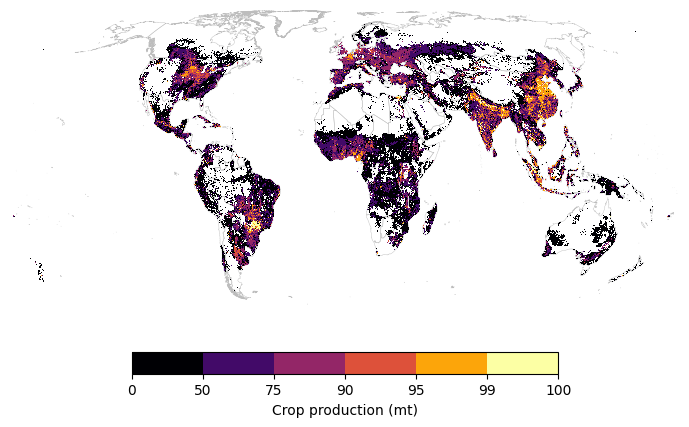

In [223]:
##### Produce global map fo crop production

# -----------------------------
# 1. Load summed raster
# -----------------------------
prod_path_out = "/Users/carinamanitius/Documents/GitHub/AgDownscaling/Data/Raw/IFPRI_MapSPAM/Crop_production_kg_2020.tif"
crop_plot = rio.open_rasterio(prod_path_out).squeeze()

# -----------------------------
# 2. Mask zeros
# -----------------------------
crop_plot_masked = crop_plot.where(crop_plot > 0.1)

# -----------------------------
# 3. Percentile breaks
# -----------------------------
values = crop_plot_masked.values
values = values[np.isfinite(values)]

breaks = np.percentile(values, [0, 50, 75, 90, 95, 99, 100])

# -----------------------------
# 4. Setup discrete colormap
# -----------------------------
cmap = plt.get_cmap("inferno", len(breaks) - 1)
cmap.set_bad("none")  # <-- makes NaN transparent
norm = BoundaryNorm(breaks, cmap.N)

# -----------------------------
# 5. Reproject the *masked* raster
# -----------------------------
crop_plot_masked_eq = crop_plot_masked.rio.reproject("EPSG:8857")

# -----------------------------
# 6. Match CRS for boundaries
# -----------------------------
country_boundaries = country_boundaries.to_crs(crop_plot_masked_eq.rio.crs)

# -----------------------------
# 7. Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(7, 5))

country_boundaries.plot(
    ax=ax,
    facecolor="none",
    edgecolor="#bdbdbd",
    linewidth=0.3,
    zorder=1
)

im = crop_plot_masked_eq.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False,
    zorder=2,
    rasterized=True
)

ax.set_axis_off()

# -----------------------------
# 8. Colorbar (legend)
# -----------------------------
cbar = fig.colorbar(
    im,
    ax=ax,
    orientation="horizontal",
    fraction=0.05,
    pad=0.04
)

cbar.set_label("Crop production (mt)")
# cbar.set_ticks(breaks)
cbar.set_ticklabels(["0", "50", "75", "90", "95", "99", "100"])

plt.tight_layout()
plt.show()

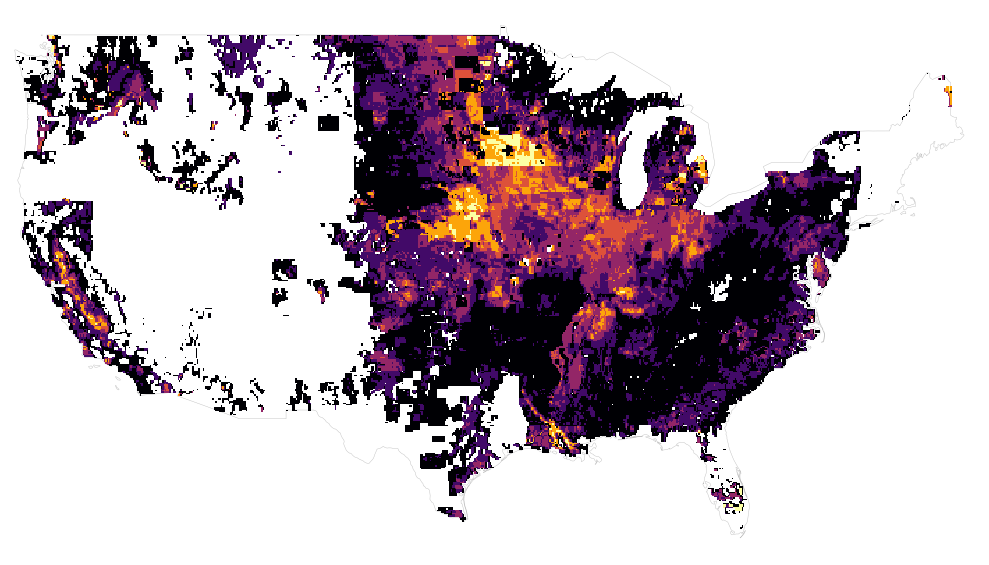

In [228]:
#### Plot crop prodcution in US

# -----------------------------
# 1. Load summed raster
# -----------------------------
prod_path_out = "/Users/carinamanitius/Documents/GitHub/AgDownscaling/Data/Raw/IFPRI_MapSPAM/Crop_production_kg_2020.tif"
crop_plot = rio.open_rasterio(prod_path_out).squeeze()

# -----------------------------
# 2. Mask zeros
# -----------------------------
crop_plot_masked = crop_plot.where(crop_plot > 0.001)

# -----------------------------
# 3. Clip to US using country boundaries
# -----------------------------
us = country_boundaries[country_boundaries["ISO"] == "US"]

# Reproject boundaries to raster CRS
us = us.to_crs(crop_plot_masked.rio.crs)

# Clip raster to US bounds
crop_us = crop_plot_masked.rio.clip(us.geometry, us.crs, drop=True)

crop_us_merc = crop_us.rio.reproject("EPSG:3857")
us_merc = us.to_crs("EPSG:3857")

# -----------------------------
# 4. Percentile breaks
# -----------------------------
values = crop_us_merc.values
values = values[np.isfinite(values)]

breaks = np.percentile(values, [0, 50, 75, 90, 95, 99, 100])

# -----------------------------
# 5. Setup discrete colormap
# -----------------------------
cmap = plt.get_cmap("inferno", len(breaks) - 1)
cmap.set_bad("none")  # makes NaN transparent
norm = BoundaryNorm(breaks, cmap.N)


# -----------------------------
# 7. Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 6))

us_merc.plot(
    ax=ax,
    facecolor="none",
    edgecolor="#bdbdbd",
    linewidth=0.3,
    zorder=1
)

im = crop_us_merc.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False,
    zorder=2,
    rasterized=True
)

# IMPORTANT: zoom to US bounds
import pyproj

proj = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
minx, miny = proj.transform(-125, 24)
maxx, maxy = proj.transform(-66, 50)

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# -----------------------------
# 8. NO Colorbar (legend removed)
# -----------------------------
ax.set_axis_off()
plt.tight_layout()
plt.show()